
# Intel® Movidius™ Neural Compute Stick (NCS)

This lab shows how the Intel® Distribution of OpenVINO™ toolkit provides hardware abstraction to run the sample object detection application which was built in previous modules on Intel® Movidius™ Neural Compute Stick.

#Importing dependencies and downloading the model files

In [24]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import time
import sys                                     
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent.parent))
from demoTools.demoutils import *
from openvino.inference_engine import IEPlugin, IENetwork
import cv2
# For labeling the image
from out_process import placeBoxes

In [2]:
! /opt/intel/openvino/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


In [3]:
!/opt/intel/openvino/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd -o models


###############|| Downloading topologies ||###############

========= Downloading models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.prototxt
... 100%, 28 KB, 63609 KB/s, 0 seconds passed

========= Downloading models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
... 100%, 22605 KB, 22281 KB/s, 1 seconds passed


###############|| Post processing ||###############




    
## Run the sample application on Intel® Movidius™ Neural Compute Stick (NCS)

Set target hardware as Intel® Movidius™ NCS with -d MYRIAD

In [4]:
! cd models/object_detection/common/mobilenet-ssd  && mkdir -p FP16 && mkdir -p FP32

In [5]:
! python3 mo_caffe.py --input_model models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel -o models/object_detection/common/mobilenet-ssd/FP16/ --scale 256 --mean_values [127,127,127] --data_type FP16

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u28225/Reference-samples/smart-video-workshop_30sepbackup/HW-Acceleration-with-Movidious-NCS/Python/models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u28225/Reference-samples/smart-video-workshop_30sepbackup/HW-Acceleration-with-Movidious-NCS/Python/models/object_detection/common/mobilenet-ssd/FP16/
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specif



You will get an error as Intel® Movidius™ NCS supports only FP16 format. 

<img src="FP32.png">


The Model Optimizer by default generate FP32 IR files if the data type is not particularly specified.

Let's run the Model Optimizer to get IR files in FP16 format suitable for the Intel® Movidius™ NCS by setting the data_type flag to FP16.

In [6]:
!python3 mo_caffe.py --input_model models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel -o models/object_detection/common/mobilenet-ssd/FP32 --scale 256 --mean_values [127,127,127] 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u28225/Reference-samples/smart-video-workshop_30sepbackup/HW-Acceleration-with-Movidious-NCS/Python/models/object_detection/common/mobilenet-ssd/caffe/mobilenet-ssd.caffemodel
	- Path for generated IR: 	/home/u28225/Reference-samples/smart-video-workshop_30sepbackup/HW-Acceleration-with-Movidious-NCS/Python/models/object_detection/common/mobilenet-ssd/FP32
	- IR output name: 	mobilenet-ssd
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
Caffe specifi


    
Check if the .xml and .bin files are created in folder $SV/object-detection/mobilenet-ssd/FP16.

In [7]:
 !cd models/object_detection/common/mobilenet-ssd/FP32 && ls

mobilenet-ssd.bin  mobilenet-ssd.mapping  mobilenet-ssd.xml



    
Now run the example application with these new IR files.

In [25]:
%%writefile object_detection_job_ex.sh

ME=`basename $0`

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR

# Object detection script writes output to a file inside a directory. We make sure that this directory exists.
# The output directory is the first argument of the bash script
while getopts 'd:f:i:r:n:?' OPTION; do
    case "$OPTION" in
    d)
        DEVICE=$OPTARG
        echo "$ME is using device $OPTARG"
      ;;

    f)
        FP_MODEL=$OPTARG
        echo "$ME is using floating point model $OPTARG"
      ;;

    i)
        INPUT_FILE=$OPTARG
        echo "$ME is using input file $OPTARG"
      ;;
    r)
        RESULTS_BASE=$OPTARG
        echo "$ME is using results base $OPTARG"
      ;;
    n)
        NUM_INFER_REQS=$OPTARG
        echo "$ME is running $OPTARG inference requests"
      ;;
    esac  
done

NN_MODEL="mobilenet-ssd.xml"
RESULTS_PATH="${RESULTS_BASE}"
mkdir -p $RESULTS_PATH
echo "$ME is using results path $RESULTS_PATH"

if [ "$DEVICE" = "HETERO:FPGA,CPU" ]; then
    # Environment variables and compilation for edge compute nodes with FPGAs
    export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/opt/altera/aocl-pro-rte/aclrte-linux64/
    # Environment variables and compilation for edge compute nodes with FPGAs
    source /opt/fpga_support_files/setup_env.sh
    aocl program acl0 /opt/intel/openvino/bitstreams/a10_vision_design_bitstreams/2019R1_PL1_FP11_MobileNet_Clamp.aocx
fi
    
# Running the object detection code
SAMPLEPATH=$PBS_O_WORKDIR
python3 tutorial1.py                        -m models/object_detection/common/mobilenet-ssd/${FP_MODEL}/${NN_MODEL}  \
                                            -i $INPUT_FILE \
                                            -o $RESULTS_PATH \
                                            -d $DEVICE \
                                            -nireq $NUM_INFER_REQS \
                                            -ce /opt/intel/openvino/deployment_tools/inference_engine/lib/intel64/libcpu_extension_avx2.so

g++ -std=c++14 ROI_writer.cpp -o ROI_writer  -lopencv_core -lopencv_videoio -lopencv_imgproc -lopencv_highgui  -fopenmp -I/opt/intel/openvino/opencv/include/ -L/opt/intel/openvino/opencv/lib/
# Rendering the output video
SKIPFRAME=1
RESOLUTION=0.5
./ROI_writer $INPUT_FILE $RESULTS_PATH $SKIPFRAME $RESOLUTION

Overwriting object_detection_job_ex.sh


In [26]:
os.environ["VIDEO"] = "cars_1900.mp4"

# Intel® Movidius™ NCS supports only FP16 format. So it throws an FP32 precision error as seen below for FP32 format.

In [14]:
#Submit job to the queue
job_id_ncs2 = !qsub object_detection_job_ex.sh -l nodes=1:idc004nc2:intel-ncs2 -F "-r results/ncs2 -d MYRIAD -f FP32 -i $VIDEO -n 8" -N obj_det_ncs2
print(job_id_ncs2[0]) 
#Progress indicators
time.sleep(90)
var=job_id_ncs2[0].split(".")
list=var[0]
fin="obj_det_ncs2.e"+list
! cat $fin

58873.c003
Traceback (most recent call last):
  File "tutorial1.py", line 234, in <module>
    sys.exit(main() or 0)
  File "tutorial1.py", line 131, in main
    exec_net = plugin.load(network=net, num_requests=args.number_infer_requests)
  File "ie_api.pyx", line 395, in openvino.inference_engine.ie_api.IEPlugin.load
  File "ie_api.pyx", line 406, in openvino.inference_engine.ie_api.IEPlugin.load
RuntimeError: [VPU] Unsupported network precision : FP32


In [27]:
#Submit job to the queue
job_id_ncs2 = !qsub object_detection_job_ex.sh -l nodes=1:idc004nc2:intel-ncs2 -F "-r results/ncs2 -d MYRIAD -f FP16 -i $VIDEO -n 8" -N obj_det_ncs2
print(job_id_ncs2[0]) 
#Progress indicators
if job_id_ncs2:
    progressIndicator('results/ncs2', 'pre_progress.txt', "Preprocessing", 0, 100)
    progressIndicator('results/ncs2', 'i_progress.txt', "Inference", 0, 100)
    progressIndicator('results/ncs2', 'post_progress.txt', "Rendering", 0, 100)

59695.c003


In [28]:
videoHTML('IEI Tank (Intel  Movidius)', 
          ['results/ncs2/output.mp4'])

In [29]:
#Submit job to the queue
job_id_core = !qsub object_detection_job_ex.sh -l nodes=1:tank-870:i5-6500te -F "-r results/Core -d CPU -f FP32 -i $VIDEO -n 2" -N obj_det_core
print(job_id_core[0]) 
#Progress indicators
if job_id_core:
    progressIndicator('results/Core', 'pre_progress.txt', "Preprocessing", 0, 100)
    progressIndicator('results/Core', 'i_progress.txt', "Inference", 0, 100)
    progressIndicator('results/Core', 'post_progress.txt', "Rendering", 0, 100)

59696.c003


In [31]:
videoHTML('IEI Tank (Intel  Movidius)', 
          ['results/Core/output.mp4'])

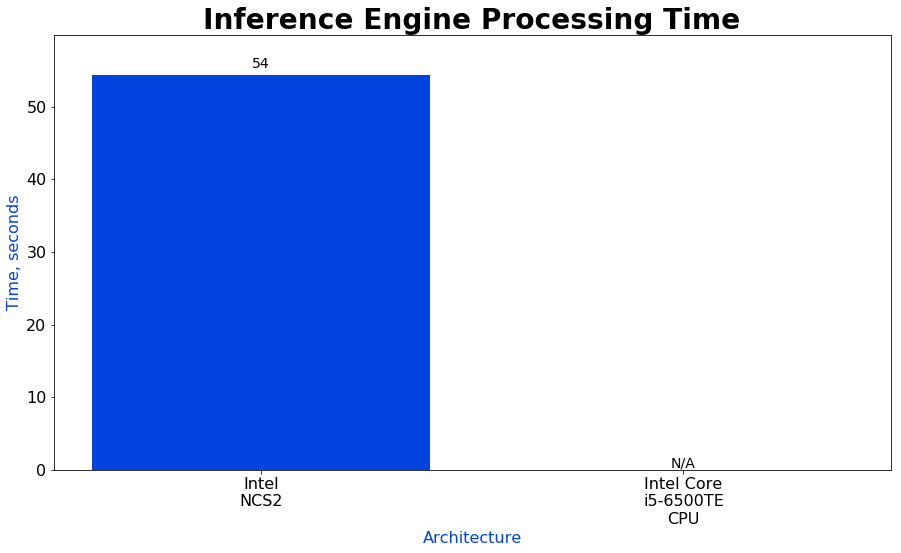

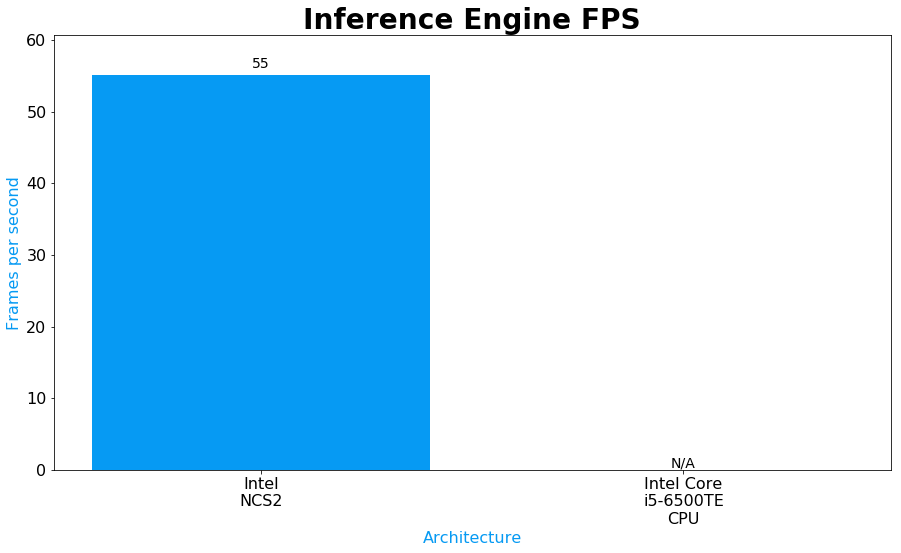

In [36]:
arch_list = [('ncs2', 'Intel\nNCS2'),
             ('Core', 'Intel Core\ni5-6500TE\nCPU')]
stats_list = []
for arch, a_name in arch_list:
    if 'job_id_'+arch in vars():
        stats_list.append(('results/{arch}/stats.txt'.format(arch=arch), a_name))
    else:
        stats_list.append(('placeholder'+arch, a_name))

summaryPlot(stats_list, 'Architecture', 'Time, seconds', 'Inference Engine Processing Time', 'time' )
summaryPlot(stats_list, 'Architecture', 'Frames per second', 'Inference Engine FPS', 'fps' )